# Group014 - Assignment 4

Name: Shantanu Shastri

Student ID: 30387612

Name: Rohan Paithankar

Student ID: 30131502

# Task 1

## Importing Relevant Libraries

In [1]:
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import geopandas as gpd
from shapely.geometry import Point,shape
from shapely.geometry.polygon import Polygon
from datetime import datetime
import codecs
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import math

## Unzipping the Files

Loading the zipped gtfs file and unzipping only the relevant folders (1 and 2) containing Local and Regional Trains data out of the 11 folders and extracting it. `Commented so as to avoid errors for path.`

In [2]:
#import zipfile
#with zipfile.ZipFile('gtfs/1/google_transit.zip', 'r') as zip_ref:
#    zip_ref.extractall('gtfs/1/')
#with zipfile.ZipFile('gtfs/2/google_transit.zip', 'r') as zip_ref:
#    zip_ref.extractall('gtfs/2/') 

## Loading Data
Loading the .shp shape data using geopandas library and converting it into a dataframe using pandas. Also, loading the Property data using pandas library.

In [3]:
shapeFile = gpd.read_file('vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp')
shapeFile_df = pd.DataFrame(shapeFile)
houses = pd.read_csv('Properties.csv')

## Adding Suburbs using Polygon
For adding suburbs, we checked whether the latitude and longitude of the Property provided lies within any of the shape(which consists of multiple latitudes and longitudes) using contains and if matched, then assigned the corresponding suburb name to the column Suburb.

In [4]:
houses['Suburb'] = 'not available'   #Default value

In [5]:
for i,polygon in shapeFile_df.iterrows():
    sub = shape(polygon['geometry'])
    for j,house in houses.iterrows():
        if sub.contains(Point(house['Longtitude'],house['Lattitude'])):
            houses['Suburb'].loc[j] = shapeFile_df['VIC_LOCA_2'].loc[i]

/Users/rohan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Removing Departure times which are outside 7-9:30am

We loaded data from folder 1(Local) and folder 2(Regional) into local_trips and regional_trips respectively. We further eliminated the the rows where the departure time from the suburb was greater than 09:30 or less than 07:00 in the morning.

In [6]:
local_trips = pd.read_csv('2/stop_times.txt',sep = ',')
#-----------
regional_trips = pd.read_csv('1/stop_times.txt',sep = ',')

In [7]:
#------------------------Local Trips----------------------------#
print(local_trips.count())
drop_rows = []
for i, row in local_trips.iterrows():
    if (row['departure_time'].startswith('24') or row['departure_time'].startswith('25') or row['departure_time'].startswith('26') or row['departure_time'].startswith('27')):
        drop_rows.append(i)
    elif((datetime.strptime(row['departure_time'],'%H:%M:%S') < datetime.strptime("07:00:00",'%H:%M:%S'))):
         drop_rows.append(i)
    elif (datetime.strptime(row['departure_time'],'%H:%M:%S') > datetime.strptime("09:30:00",'%H:%M:%S')) and (row['stop_id']!= 22180):
        drop_rows.append(i)
local_trips = local_trips.drop(drop_rows)
print(local_trips.count())


#----------------------Regional Trips---------------------------#

print(regional_trips.count())
drop_rows_r = []
for i,row in regional_trips.iterrows():
    if (row['departure_time'].startswith('24') or row['departure_time'].startswith('25') or row['departure_time'].startswith('26') or row['departure_time'].startswith('27')):
        drop_rows_r.append(i)
    elif((datetime.strptime(row['departure_time'],'%H:%M:%S') < datetime.strptime("07:00:00",'%H:%M:%S'))):
         drop_rows_r.append(i)
    elif (datetime.strptime(row['departure_time'],'%H:%M:%S') > datetime.strptime("09:30:00",'%H:%M:%S')) and (row['stop_id']!= 20043):
        drop_rows_r.append(i)
regional_trips = regional_trips.drop(drop_rows_r)
print(regional_trips.count())

trip_id                469488
arrival_time           469488
departure_time         469488
stop_id                469488
stop_sequence          469488
stop_headsign               0
pickup_type            469488
drop_off_type          469488
shape_dist_traveled    469296
dtype: int64
trip_id                80979
arrival_time           80979
departure_time         80979
stop_id                80979
stop_sequence          80979
stop_headsign              0
pickup_type            80979
drop_off_type          80979
shape_dist_traveled    80970
dtype: int64
trip_id                72489
arrival_time           72489
departure_time         72489
stop_id                72489
stop_sequence          72489
stop_headsign              0
pickup_type            72489
drop_off_type          72489
shape_dist_traveled    72489
dtype: int64
trip_id                15228
arrival_time           15228
departure_time         15228
stop_id                15228
stop_sequence          15228
stop_headsign           

Further, we converted the departure_time and arrival_time from String into datetime data type.

In [8]:
#------------------Local Trips-------------------------#
local_trips["departure_time"] = pd.to_datetime(local_trips["departure_time"],format= '%H:%M:%S' )
local_trips["arrival_time"] = pd.to_datetime(local_trips["arrival_time"],format= '%H:%M:%S' )

#------------------Regional Trips----------------------#

regional_trips["departure_time"] = pd.to_datetime(regional_trips["departure_time"],format= '%H:%M:%S' )
regional_trips["arrival_time"] = pd.to_datetime(regional_trips["arrival_time"],format= '%H:%M:%S' )


## Removal of those trips from local_trips that operate on weekends
Inorder to extract only the weekday trips , we followed the following steps:
Loaded data from calendar.txt into a dataframe called local_calendar for the local data and regional_calendar for regional data.
We extracted the service id's from the file where either of the weekend values are 1 inorder to get service id's of only the weekday trips and created a list of service id's called weekend_trips_r and weekend_trips_l for the regional and local respectively.
We then filtered out the trips from stop_times.txt using the service id list extracted from calendar.txt.

In [9]:
#----------------------Local-------------------------#
local_routes = pd.read_csv('2/routes.txt',sep = ',')

#-----------------------Regional---------------------#
regional_routes = pd.read_csv('1/routes.txt',sep = ',')

### Creating list of trips on the weekends

In [10]:
#-----------------------Local---------------------#
local_calendar = pd.read_csv('2/calendar.txt',sep = ',')
weekend_trips_l = []
for i, row in local_calendar.iterrows():
    if row['saturday'] == 1 or row['sunday'] == 1:
        weekend_trips_l.append(row['service_id'])


#-----------------------Regional---------------------#
regional_calendar = pd.read_csv('1/calendar.txt',sep = ',')
weekend_trips_r = []
for i, row in regional_calendar.iterrows():
    if row['saturday'] == 1 or row['sunday'] == 1:
        weekend_trips_r.append(row['service_id'])

weekend_trips = set(weekend_trips_l + weekend_trips_r)
print(weekend_trips)

{'UJ_5', 'UJ_4', 'T2_4', 'T2', 'UJ_2', 'UJ_3', 'T2_5', 'UJ', 'UJ_1', 'T2_2', 'T2_3', 'T2_1'}


### Removing weekend trips 
Using the list of service_ids weekend_trips_r and weekend_trips_l, we eliminated the trips that were running on weekends from our local_trips and regional_trips dataframe so that we have only the relevant trips for further operations.

In [11]:
#-------------------Local------------------------#
print(local_trips.count())
drop_weekend_trips_l = []
for i,row in local_trips.iterrows():
    for service in weekend_trips:
        if (service in row['trip_id']):
            drop_weekend_trips_l.append(i)
local_trips = local_trips.drop(drop_weekend_trips_l)
print(local_trips.count())

#-------------------Regional---------------------#
print(regional_trips.count())
drop_weekend_trips_r = []
for i,row in regional_trips.iterrows():
    for service in weekend_trips:
        if (service in row['trip_id']):
            drop_weekend_trips_r.append(i)
regional_trips = regional_trips.drop(drop_weekend_trips_r)
print(regional_trips.count())


trip_id                80979
arrival_time           80979
departure_time         80979
stop_id                80979
stop_sequence          80979
stop_headsign              0
pickup_type            80979
drop_off_type          80979
shape_dist_traveled    80970
dtype: int64
trip_id                58939
arrival_time           58939
departure_time         58939
stop_id                58939
stop_sequence          58939
stop_headsign              0
pickup_type            58939
drop_off_type          58939
shape_dist_traveled    58939
dtype: int64
trip_id                15228
arrival_time           15228
departure_time         15228
stop_id                15228
stop_sequence          15228
stop_headsign              0
pickup_type            15228
drop_off_type          15228
shape_dist_traveled    15228
dtype: int64
trip_id                9615
arrival_time           9615
departure_time         9615
stop_id                9615
stop_sequence          9615
stop_headsign             0
pickup_typ

### Filtering trips that go to Southern Cross

Inorder to get direct trips from stations to southern cross station, we filtered out the trips which do not contain the station id 22180 for local and 20043 for regional respectively inroder to be left with only the relevant trips which include southern cross station in them.
We created a list drop_trips for local and drop_trips_r for regional inroder to store the indexes of the trips which do not have southern cross station in them and we dropped them from our dataframe local_trips and regional_trips.

In [12]:
#------------------------Local--------------------#
local_trips['time_to_sc'] = 0
trips_to_sc = []
sc = []
for i,row in local_trips.iterrows():
    if(row['stop_id'] == 22180):
        trips_to_sc.append(row['trip_id'])
trips_to_sc = set(trips_to_sc)

#-----------------------Regional-------------------#

regional_trips['time_to_sc'] = 0
trips_to_sc_r = []
sc = []
for i,row in regional_trips.iterrows():
    if(row['stop_id'] == 20043):
        trips_to_sc_r.append(row['trip_id'])
trips_to_sc_r = set(trips_to_sc_r)


We create a set of trip ids involving southern cross stations inorder to create a dictionary of arrival time at southern cross for each trip.
We created a set from list called trips_to_sc for storing all the trip ids of the trips which involve southern cross station.
We followed the same procedure for the regional as well.

In [13]:
#------------------------Local-------------------#
drop_trips = []                      #Remove trips that do not include southern cross
for i,row in local_trips.iterrows():
    if row['trip_id'] not in trips_to_sc:
        drop_trips.append(i)
local_trips = local_trips.drop(drop_trips)
local_trips.head()

#------------------------Regional-----------------#

drop_trips_r = []                      #Remove trips that do not include southern cross
for i,row in regional_trips.iterrows():
    if row['trip_id'] not in trips_to_sc_r:
        drop_trips_r.append(i)
regional_trips = regional_trips.drop(drop_trips_r)
regional_trips.head()


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,time_to_sc
3,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 07:16:00,1900-01-01 07:16:00,20339,4,NaN,0,0,94514.728171,0
4,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 07:32:00,1900-01-01 07:34:00,20351,5,NaN,0,0,116895.210301,0
5,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 07:45:00,1900-01-01 07:45:00,20330,6,NaN,0,0,130530.089787,0
6,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 07:57:00,1900-01-01 07:57:00,20328,7,NaN,0,0,145000.117101,0
7,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 08:16:00,1900-01-01 08:16:00,20357,10,NaN,0,0,175519.536474,0


### Dictionary of Arrival times at southern cross from each station 
We create a dictionary called southern_cross_trips and southern_cross_trips_r for local and regional data respectively. We calculated the arrival time of the train at southern cross station in each of trips for the local and regional data.

In [14]:
#--------------------------------Local-----------------------#
southern_cross_trips = {}
for i,row in local_trips.iterrows():
    if row['stop_id'] == 22180:
        southern_cross_trips[row['trip_id']] = row['arrival_time']
        
#--------------------------------Regional-----------------------#

southern_cross_trips_r = {}
for i,row in regional_trips.iterrows():
    if row['stop_id'] == 20043:
        southern_cross_trips_r[row['trip_id']] = row['arrival_time']

### Calculating Time to Southern cross from each station

For simplifying the calculation of travel_min_to_CBD,we created a column time_to_sc in our local_trips and regional_trips which holds the value of time required to travel from each station to southern cross in minutes.
time_to_sc is the difference between departure times from each station in a particular trip and arrival time at southern cross in that particular trip.

In [15]:
#-------------------Local--------------------#
for i,row in local_trips.iterrows():
    if southern_cross_trips[row['trip_id']] > row['departure_time']:
        local_trips['time_to_sc'].loc[i] = (southern_cross_trips[row['trip_id']] - row['departure_time']).seconds/60
local_trips.head(5) 

#-------------------Regional--------------------#

for i,row in regional_trips.iterrows():
    if southern_cross_trips_r[row['trip_id']] > row['departure_time']:
        regional_trips['time_to_sc'].loc[i] = (southern_cross_trips_r[row['trip_id']] - row['departure_time']).seconds/60
regional_trips.head(5) 


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,time_to_sc
3,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 07:16:00,1900-01-01 07:16:00,20339,4,NaN,0,0,94514.728171,161.0
4,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 07:32:00,1900-01-01 07:34:00,20351,5,NaN,0,0,116895.210301,143.0
5,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 07:45:00,1900-01-01 07:45:00,20330,6,NaN,0,0,130530.089787,132.0
6,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 07:57:00,1900-01-01 07:57:00,20328,7,NaN,0,0,145000.117101,120.0
7,7548.UR.1-V08-A-mjp-1.1.H,1900-01-01 08:16:00,1900-01-01 08:16:00,20357,10,NaN,0,0,175519.536474,101.0


We finally merge the local_trips and regional_trips data into a single dataframe called trips using pd.concat from the pandas library which involve only those trips which:
Run on weekdays
Are between 07:00 and 09:30 am.
Have southern cross station in them.

In [16]:
trips = pd.concat([local_trips,regional_trips],ignore_index=True)


### Distance to Closest Station from Property
We calculated the train_station_id and distance_to_train_station by following the steps below:
Loaded data from stops.txt into stops_l and stops_r.
We merged the data into stops using pd.concat from pandas library.
Assigning train_station_id and distance_to_train_station to initial value of 1.
We calculate the distance using the distance formula by using sin,cos and atan.
We then store the distance from each property to every station in the particular trip.
We calculate the minimum distance using min and assign the distance to the column distance_to_train_station with the distance.
We further assign the value of corresponding station_id to the column train_station_id by using the minimum distance.

In [17]:
from math import sin,cos,sqrt,atan2,radians
stops_l = pd.read_csv('2/stops.txt',sep = ',')
stops_r = pd.read_csv('1/stops.txt',sep = ',')

#Merging the data into single dataframe
stops = pd.concat([stops_l,stops_r],ignore_index = True)

#Assigning initial value to -1
houses['train_station_id'] = -1
houses['distance_to_train_station'] = -1

#Radius of earth 
R = 6378.0

for i,row in houses.iterrows():
    distance = []            # List to store the distances from property to each station
    ids = []
    for j,row1 in stops.iterrows():

        lat1 = radians(row['Lattitude'])     #Latitude of property
        lon1 = radians(row['Longtitude'])    #longitude of property
        lat2 = radians(row1['stop_lat'])      #Latitude of station
        lon2 = radians(row1['stop_lon'])     #Longitude of station

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        
    
        ids.append(row1['stop_id'])
        distance.append(R * c)              #Appending every distance to the list
    
    min_dist = min(distance)
    houses['distance_to_train_station'].loc[i] = min_dist*1000  #Assigning the minimum distance to the column 
    train_st_id = ids[distance.index(min_dist)]
    houses['train_station_id'].loc[i] = train_st_id             #Assigning the corresponding station id to the column
houses.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station
0,ID441936550,414/99 Dow St,2,u,845000.0,7/05/2016,2.0,2.0,2166.0,29.0,-37.84150,144.94120,PORT MELBOURNE,20043,2764.295334
1,ID874566543,30 Cedar St,2,h,1001000.0,26/07/2016,2.0,1.0,255.0,129.0,-37.88870,145.02070,CAULFIELD SOUTH,19953,1703.266867
2,ID483823554,5a Compton St,2,u,695000.0,27/05/2017,1.0,1.0,300.0,8.0,-37.80574,145.18832,MITCHAM,19900,1403.129566
3,ID591113817,4/287 Albion St,1,h,412000.0,8/04/2017,1.0,1.0,85.0,119.0,-37.75980,144.95630,BRUNSWICK,19967,417.877937
4,ID531857796,1 Ashdown Ct,3,h,671000.0,26/08/2017,1.0,2.0,418.0,89.0,-37.66349,145.03391,LALOR,20005,1280.233751


### Calculating Average time to Southern cross
Inorder to calculate travel_min_to_CBD, we use the dictionary southern_cross_trips for the arrival times at southern cross in each trip. We also use time_to_sc column which stores the time in minutes from each styation to southern cross.
We initialize two variable total_time and num_of_trips to 0. We add up the values from the column time_to_sc in each trip to total_time and increment the num_of_trips by 1 to further calculate the average time to travel to Southern cross by dividing the both and assining the value to travel_min_to_CBD.

In [18]:
# Assingning initial value to the column
houses['travel_min_to_CBD'] = -1
for i,row in houses.iterrows():
    total_time = 0              # Sum of total minutes from each station to southern cross
    num_of_trips = 0            #Count
    for j,row1 in trips[trips['stop_id'] == row['train_station_id']].iterrows():
        total_time+=row1['time_to_sc']
        num_of_trips += 1
    if(num_of_trips != 0):
        houses['travel_min_to_CBD'].loc[i] = total_time/num_of_trips    # Average time to CBD
houses.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID441936550,414/99 Dow St,2,u,845000.0,7/05/2016,2.0,2.0,2166.0,29.0,-37.84150,144.94120,PORT MELBOURNE,20043,2764.295334,0.000000
1,ID874566543,30 Cedar St,2,h,1001000.0,26/07/2016,2.0,1.0,255.0,129.0,-37.88870,145.02070,CAULFIELD SOUTH,19953,1703.266867,15.555556
2,ID483823554,5a Compton St,2,u,695000.0,27/05/2017,1.0,1.0,300.0,8.0,-37.80574,145.18832,MITCHAM,19900,1403.129566,31.515152
3,ID591113817,4/287 Albion St,1,h,412000.0,8/04/2017,1.0,1.0,85.0,119.0,-37.75980,144.95630,BRUNSWICK,19967,417.877937,5.266667
4,ID531857796,1 Ashdown Ct,3,h,671000.0,26/08/2017,1.0,2.0,418.0,89.0,-37.66349,145.03391,LALOR,20005,1280.233751,14.089172


## Web Scraping for school details

For the fields related to primary and secondary schools, we have been provided with two websites.

Primary School details - http://www.schoolcatchment.com.au/?p=12301

Secondary School details - https://sites.google.com/a/monash.edu/secondary-school-ranking/

We need to crawl the two websites above in order to extract school names and their rankings.

We start with extracting primary school details as follows:

- We create a BeautifulSoup object `bsobj`.
- We extract all the information under the attribute class `row-hower` and `column-1` for primary school ranks and append to the list `ranks_primary`.
- We extract all the information under the attribute class `row-hower` and `column-2` for primary school names and append to the list `names_primary`.
- We ensure that if there are repeating names in the list, they hold the lowest ranking for that particular school.
- We create a dictionary `d_prim` which holds the primary school name as key and lowest ranking as the value.

In [19]:
##Dictionary of Primary Schools with rankings

html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
bsobj = BeautifulSoup(html, 'html.parser')


ranks_primary = []
names_primary = []
for x in bsobj.find(class_ = 'row-hover').findAll(class_ = 'column-1'):
    ranks_primary.append(int(x.contents[0]))
for y in bsobj.find(class_ = 'row-hover').findAll(class_ = 'column-2'):
    names_primary.append(y.contents[0])
    
#Dictionary of Primary school with names and rank
#primary_schools = {}
for i in range(0,len(names_primary)):              #Setting all ranks of following entries as the lowest rank
    for j in range(i+1,len(names_primary)):
        if names_primary[i] == names_primary[j]:
            ranks_primary[j] = ranks_primary[i]
d_prim= dict(zip(names_primary,ranks_primary))


We repeat the same procedure for secondary school details. Here there is an additional step of sort the ranks as the information is unordered.

We start with extracting secondary school details as follows:

- We create a BeautifulSoup object `bsobj`.
- We extract all the information under the tag `li` and use the regex `<li>\n<div>.*?</div>\n<div>(-?\d*%?)?</div>\n` to extract the ranks. This regex only takes those fields in the div tag which appears second in the list of div tags.The ranks are appended to the list `ranks_sec`.
- We extract all the information under the tag `li` and use the regex `<li>\n<div>(.+?)</div>` to extract names. This regex only reads the first div field. The names are appeneded to the list `names_sec`.
- We then sort the list `ranks_sec` in ascending order and also arrange the list `names_sec` accordingly.
- We ensure that if there are repeating names in the list, they hold the lowest ranking for that particular school.
- We create a dictionary `d_sec` which holds the primary school name as key and lowest ranking as the value.

#### Note: The source code fro secondary schools was saved in the file Secondary_schools.html because the webpage requires login.

In [20]:
#Dictionary of Secondary Schools with rankings

f = codecs.open("Secondary_schools.html", 'r', 'utf-8')
bsobj1 = BeautifulSoup(f, 'html.parser')

r_obj = bsobj1.findAll('li')
ranks_sec = re.findall('<li>\n<div>.*?</div>\n<div>(-?\d*%?)?</div>\n',str(r_obj))
ranks_sec = list(map(int,ranks_sec))    

names_sec = re.findall('<li>\n<div>(.+?)</div>',str(r_obj))

for i in range(0,len(ranks_sec)):
    for j in range(0,len(ranks_sec)-i-1):
        if ranks_sec[j] > ranks_sec[j+1]:
            temp1 = ranks_sec[j]
            ranks_sec[j] = ranks_sec[j+1]
            ranks_sec[j+1] = temp1
            temp2 = names_sec[j]
            names_sec[j] = names_sec[j+1]
            names_sec[j+1] = temp2
for i in range(0,len(names_sec)):              #Setting all ranks of following entries as the lowest rank
    for j in range(i+1,len(names_sec)):
        if names_sec[i] == names_sec[j]:
            ranks_sec[j] = ranks_sec[i]
            
d_sec = dict(zip(names_sec,ranks_sec))





### Calculating distance from property to the closest school

We follow the steps given below to achieve this:  

- We first create a dataframe consisting of all schools, with their corresponding school type and coordinates. We extract these values from `schools.xml` file using regex expressions for each of the tags. After extracting, we convert latitude and longitude into the appropriate datatype. The end result is the dataframe `schools_df`.


In [21]:
# Creating a dataframe of schools

s = codecs.open('schools.xml', 'r', 'utf-8')
sobj = BeautifulSoup(s , 'lxml')

schools = sobj.find_all('school')
cities = []
school_name = []
longitude = []
latitude = []
Type = []
for school in schools:
    school_name.extend(re.findall('<school_name>(.+?)</school_name>',str(school)))
    longitude.extend(re.findall('<x>(.+?)</x>',str(school)))
    latitude.extend(re.findall('<y>(.+?)</y>',str(school)))
    Type.extend(re.findall('<school_type>(.+?)</school_type>',str(school)))
#print(len(longitude),len(cities),len(latitude),len(school_name),len(Type))


latitude = [float(i) for i in latitude]
longitude = [float(i) for i in longitude]
for i in range(1,len(cities)):
    new_city = re.findall(r'(.*?)\s\(',cities[i])
    cities[i] = new_city

schools_df = pd.DataFrame({'school_name':school_name,'School_Type':Type,'latitude':latitude,'longitude':longitude})
schools_df.head()

    

,school_name,School_Type,latitude,longitude
0,Alberton Primary School,Primary,-38.617713,146.666601
1,Allansford and District Primary School,Primary,-38.386281,142.590393
2,Avoca Primary School,Primary,-37.084502,143.475649
3,Avenel Primary School,Primary,-36.901368,145.234722
4,Warrandyte Primary School,Primary,-37.742675,145.213980


### Closest Name of Primary Schools along with Distance and Ranking

- Adding the necessary columns with default values.

In [22]:
houses['closest_primary_school'] = 'not available'
houses['distance_to_closest_primary'] = -1
houses['primary_school_ranking'] = -1
houses['closest_secondary_school'] = 'not available'
houses['distance_to_closest_secondary'] = -1
houses['secondary_school_ranking'] = -1

Using the lenght of arc formula, we calculate the distance from properties to the primary schools. The closest one is added to the `houses` dataframe along with the distance and ranking.

In [23]:
R = 6378.0

for i,row in houses.iterrows():
    distance_p = []
    rank_p = []
    name_p = []
    
    for j,row1 in schools_df.iterrows():
        
        type_school = row1['School_Type'] 
        
        if type_school == 'Primary':
            if row1['school_name'] in names_primary: 

                lat1 = radians(row['Lattitude'])
                lon1 = radians(row['Longtitude'])
                lat2 = radians(row1['latitude'])
                lon2 = radians(row1['longitude'])
                dlon = lon2 - lon1
                dlat = lat2 - lat1
                a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))
                d_p  = R * c

                distance_p.append(d_p)
                name_p.append(row1['school_name'])
                rank_p.append(d_prim[row1['school_name']])
            
    min_dist_p = min(distance_p)
    idx = distance_p.index(min_dist_p)
        
    houses['distance_to_closest_primary'].loc[i] = min_dist_p*1000
    houses['closest_primary_school'].loc[i] = name_p[idx] 
    houses['primary_school_ranking'].loc[i] = rank_p[idx]   

### Closest Name of Secondary Schools along with Distance and Ranking

Using the lenght of arc formula, we calculate the distance from properties to the secondary schools. The closest one is added to the `houses` dataframe along with the distance and ranking.

In [24]:
R = 6378.0

for i,row in houses.iterrows():
    distance_s = []
    rank_s = []
    name_s = []
    
    for j,row1 in schools_df.iterrows():
        
        type_school = row1['School_Type'] 
        
        if type_school == 'Secondary':
            if row1['school_name'] in names_sec: 

                lat1 = radians(row['Lattitude'])
                lon1 = radians(row['Longtitude'])
                lat2 = radians(row1['latitude'])
                lon2 = radians(row1['longitude'])
                dlon = lon2 - lon1
                dlat = lat2 - lat1
                a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))
                d_s  = R * c

                distance_s.append(d_s)
                name_s.append(row1['school_name'])
                rank_s.append(d_sec[row1['school_name']])
            
    min_dist_s = min(distance_s)
    idx = distance_s.index(min_dist_s)
        
    houses['distance_to_closest_secondary'].loc[i] = min_dist_s*1000
    houses['closest_secondary_school'].loc[i] = name_s[idx] 
    houses['secondary_school_ranking'].loc[i] = rank_s[idx]
    


### Crimes 

For the crimes dataset provided, some initial processing needs to be done as follows:

In [25]:
#Loading and restructuring the dataframe for Crimes

xls = pd.ExcelFile('crimebylocationdatatable-yearending31march2016.xlsx')
crimes = pd.read_excel(xls, 'Table 1')      #Access Table 1 within the excel file
crimes = crimes.iloc[18:,1:]              #Remove the initial 18 rows that have empty cells
crimes = crimes.reset_index(drop=True)    #Reset index
crimes.columns = crimes.loc[0]           #Set the first row as the column names
crimes = crimes.drop(0)                   #Delete first row
crimes = crimes.reset_index(drop=True)    #Reset index
crimes.head()   

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


In [26]:
houses["Date"] = pd.to_datetime(houses["Date"],format= '%d/%m/%Y').dt.date   #Converting date column from houses dataframe to datetime

We follow the given steps to add the values of `crime_A_average`, `crime_B_average` and `crime_C_average`:

- We first create the 3 columns with default values -1.
- We initialize the dictionary councils which holds the areas as keys and the list of suburbs as values.
- Interating through the houses dataframe, we get the year of sale for every row, and find the `min_date` and `max_date`, i.e., the years between which the average offence counts have to be calculated.
- We extract the subset of rows from crimes table for the years required and for the given area where the property is. We find the area of the property by searching for it from the `councils` dictionary.
- We count the number of entries for each category `A`, `B` and `C` and also sum their offence counts.
- Assign the average offence count(offence count/number of entries) for the corresponsing columns.

In [27]:
# Creating dictionary of cities with suburbs
councils = {}
with open("councils.txt") as f:      #initialize the dictionary councils
    for line in f:
        (key, val) = line.strip('\n').split(':')
        councils[key] = val

houses['crime_A_average'] = -1       #Creating the columns with default value
houses['crime_B_average'] = -1
houses['crime_C_average'] = -1

for i,row in houses.iterrows():
    suburb = row['Suburb']
    max_date = row['Date'].year - 1      # find the min_date and max_date
    min_date = row['Date'].year - 3
    for j in councils:
        if suburb in councils[j].upper():     
            area = j
    crimes_by_year = crimes[((crimes['Apr - Mar reference period']>= min_date) & (crimes['Apr - Mar reference period'] <= max_date))]
    crimes_by_area = crimes_by_year[crimes_by_year['Local Government Area'] == area.strip()] #extract the subset of rows from crimes table
    count_a = 0
    count_b = 0
    count_c = 0
    offence_count_a = 0
    offence_count_b = 0
    offence_count_c = 0
    
    for k,row1 in crimes_by_area.iterrows():
        if(row1['CSA Offence Division'].startswith('A')):
            count_a += 1
            offence_count_a += row1['Offence Count']
        elif(row1['CSA Offence Division'].startswith('B')):
            count_b += 1
            offence_count_b += row1['Offence Count']
        elif(row1['CSA Offence Division'].startswith('C')):
            count_c += 1
            offence_count_c += row1['Offence Count']
    houses['crime_B_average'].loc[i] = offence_count_b/count_b
    houses['crime_A_average'].loc[i] = offence_count_a/count_a
    houses['crime_C_average'].loc[i] = offence_count_c/count_c


### OverPriced

In order to find whether the property is overpriced, we find the median of all properties matching a given property and check whether the price is higher or lower than the median. The value of the column is True if the price is higher than the median and False otherwise.

In [28]:
houses['over_priced?'] = -1
for i,row in houses.iterrows():
    similar_houses = houses[(houses['Type']==row['Type'])&(houses['Bathroom']==row['Bathroom'])&(houses['Rooms']==row['Rooms'])&(houses['Car']==row['Car'])]
    median = similar_houses['Price'].median()
    if row['Price'] > median:
        houses['over_priced?'].loc[i] = bool(1)
    else:
        houses['over_priced?'].loc[i] = bool(0)
houses.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking,crime_A_average,crime_B_average,crime_C_average,over_priced?
0,ID441936550,414/99 Dow St,2,u,845000.0,2016-05-07,2.0,2.0,2166.0,29.0,...,Port Melbourne Primary School,945.937127,325,Albert Park College,654.065212,131,85.956522,1043.866667,112.777778,False
1,ID874566543,30 Cedar St,2,h,1001000.0,2016-07-26,2.0,1.0,255.0,129.0,...,Caulfield Primary School,92.884513,99,Glen Eira College,1556.642054,215,200.956522,1136.687500,143.300000,True
2,ID483823554,5a Compton St,2,u,695000.0,2017-05-27,1.0,1.0,300.0,8.0,...,Mitcham Primary School,529.381944,180,Blackburn High School,3418.658473,216,183.875000,1454.937500,194.916667,True
3,ID591113817,4/287 Albion St,1,h,412000.0,2017-04-08,1.0,1.0,85.0,119.0,...,St Margaret Mary's School,1059.681960,483,Sydney Road Community School,1205.499650,447,111.500000,355.933333,60.333333,True
4,ID531857796,1 Ashdown Ct,3,h,671000.0,2017-08-26,1.0,2.0,418.0,89.0,...,St Peter's School,1546.542145,345,St Monica's College,950.403728,250,177.478261,1281.733333,207.500000,False


### Rearranging the columns as given in the schema

In [29]:
cols = ['ID','Address', 'Suburb','Price','Type','Date', 'Rooms','Bathroom', 'Car','Landsize','Age','Lattitude','Longtitude','train_station_id','distance_to_train_station','travel_min_to_CBD','over_priced?','crime_A_average','crime_B_average','crime_C_average','closest_primary_school','distance_to_closest_primary','primary_school_ranking','closest_secondary_school','distance_to_closest_secondary','secondary_school_ranking']
houses = houses[cols]
houses.columns = ['ID','Address', 'Suburb','Price','Type','Date', 'Rooms','Bathroom', 'Car','Landsize','Age','Latitude','Longitude','train_station_id','distance_to_train_station','travel_min_to_CBD','over_priced?','crime_A_average','crime_B_average','crime_C_average','closest_primary_school','distance_to_closest_primary','primary_school_ranking','closest_secondary_school','distance_to_closest_secondary','secondary_school_ranking']

### Writing the dataframe to 'Group014_solution.csv'

In [30]:
houses.to_csv('solution.csv',index = False)

# Task 2

# Log, Square-root and Power transformations

We apply math.log(), math.sqrt() and math.pow() functions to the three columns `Room`, `Age` and `crime_C_average`. We cannot apply log() and sqrt() function to the `travel_min_to_CBD` column as there are some rows with 0's. We create new columns for each operation. We follow a naming scheme of `'column_operation'`.

In [31]:

import math
houses['Rooms_log'] = None
houses['Rooms_sqrt'] = None
houses['Rooms_pow'] = None
houses['Age_log'] = None
houses['Age_sqrt'] = None
houses['Age_pow'] = None
houses['travel_min_to_CBD_log'] = None
houses['travel_min_to_CBD_sqrt'] = None
houses['travel_min_to_CBD_pow'] = None
houses['crime_C_average_log'] = None
houses['crime_C_average_sqrt'] = None
houses['crime_C_average_pow'] = None
houses['Price_log'] = None
houses['Price_sqrt'] = None
houses['Price_pow'] = None
for i,row in houses.iterrows():
    houses['Rooms_log'].at[i] = math.log(houses["Rooms"][i])
    houses['Rooms_sqrt'].at[i] = math.sqrt(houses['Rooms'][i])
    houses['Rooms_pow'].at[i] = math.pow(houses['Rooms'][i],2)
    houses['Age_log'].at[i] = math.log(houses['Age'][i])
    houses['Age_sqrt'].at[i] = math.sqrt(houses['Age'][i])
    houses['Age_pow'].at[i] = math.pow(houses['Age'][i],2)
    houses['crime_C_average_log'].at[i] =math.log(houses['crime_C_average'][i])
    houses['crime_C_average_sqrt'].at[i] =math.sqrt(houses['crime_C_average'][i])
    houses['crime_C_average_pow'].at[i] =math.pow(houses['crime_C_average'][i],2)
    houses['Price_log'].at[i] = math.log(houses["Price"][i])
    houses['Price_sqrt'].at[i] = math.sqrt(houses["Price"][i])
    houses['Price_pow'].at[i] = math.pow(houses["Price"][i],2)

After having added all the columns, we analyze the relationship between the three columns `Room`, `Age` and `crime_C_average` with respect to `Price`.

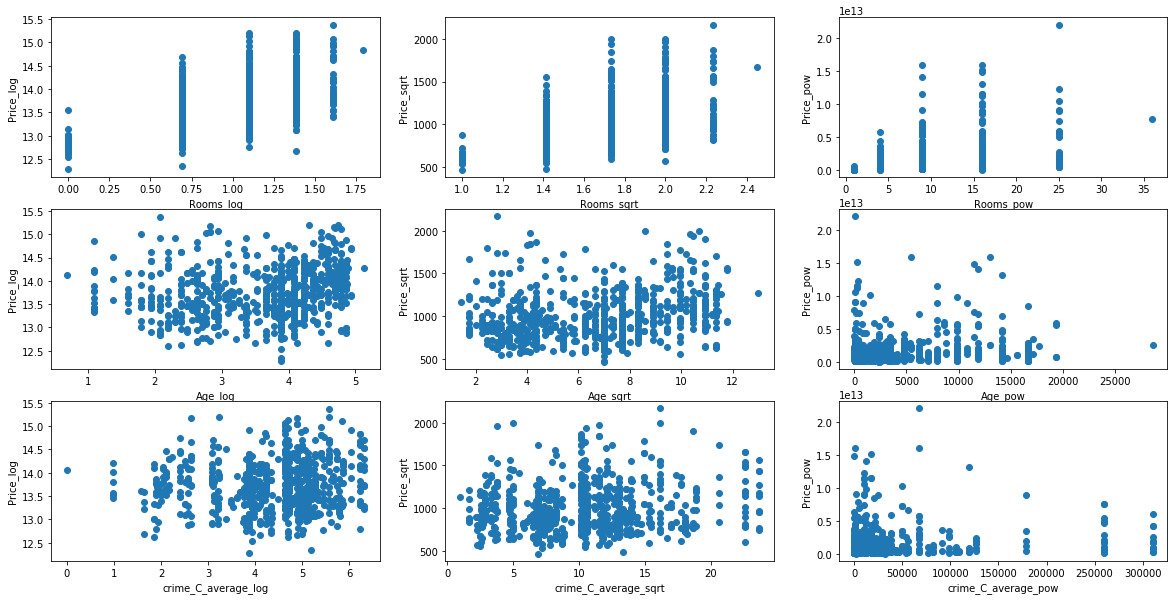

In [32]:
fig,axs = plt.subplots(3,3,figsize=(20,10))
#plt.figure()
axs[0][0].scatter(houses['Rooms_log'],houses['Price_log'])
axs[0][0].set(xlabel='Rooms_log', ylabel='Price_log')
axs[0][1].scatter(houses['Rooms_sqrt'],houses['Price_sqrt'])
axs[0][1].set(xlabel='Rooms_sqrt', ylabel='Price_sqrt')
axs[0][2].scatter(houses['Rooms_pow'],houses['Price_pow'])
axs[0][2].set(xlabel='Rooms_pow', ylabel='Price_pow')
axs[1][0].scatter(houses['Age_log'],houses['Price_log'])
axs[1][0].set(xlabel='Age_log', ylabel='Price_log')
axs[1][1].scatter(houses['Age_sqrt'],houses['Price_sqrt'])
axs[1][1].set(xlabel='Age_sqrt', ylabel='Price_sqrt')
axs[1][2].scatter(houses['Age_pow'],houses['Price_pow'])
axs[1][2].set(xlabel='Age_pow', ylabel='Price_pow')
axs[2][0].scatter(houses['crime_C_average_log'],houses['Price_log'])
axs[2][0].set(xlabel='crime_C_average_log', ylabel='Price_log')
axs[2][1].scatter(houses['crime_C_average_sqrt'],houses['Price_sqrt'])
axs[2][1].set(xlabel='crime_C_average_sqrt', ylabel='Price_sqrt')
axs[2][2].scatter(houses['crime_C_average_pow'],houses['Price_pow'])
axs[2][2].set(xlabel='crime_C_average_pow', ylabel='Price_pow')
#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')
plt.show()

We can infer from the above graphs that there is no clear relationship between these columns. We further apply Z-score normalisation to search for any valid relationship.

## Z-Score Normalisation for Rooms

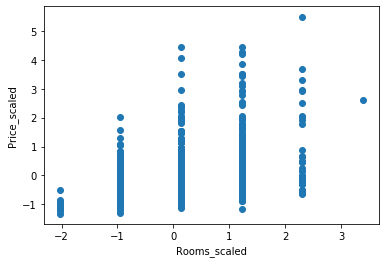

In [33]:
std_scale = preprocessing.StandardScaler().fit(houses[['Price', 'Rooms']])
df_std = std_scale.transform(houses[['Price', 'Rooms']])
houses['Price_scaled'] = df_std[:,0]
houses['Rooms_scaled'] = df_std[:,1]
plt.xlabel('Rooms_scaled')
plt.ylabel('Price_scaled')
plt.scatter(houses.Rooms_scaled,houses.Price_scaled)

There is no clear relationship between `Prices` and `Rooms`.

## Z-Score Normalisation for Property Age

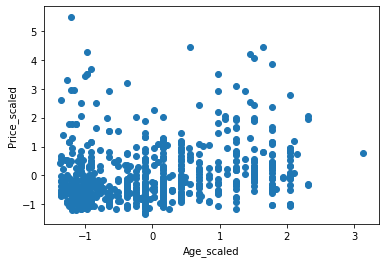

In [34]:
std_scale = preprocessing.StandardScaler().fit(houses[['Price', 'Age']])
df_std = std_scale.transform(houses[['Price', 'Age']])
houses['Price_scaled'] = df_std[:,0]
houses['Age_scaled'] = df_std[:,1]
plt.xlabel('Age_scaled')
plt.ylabel('Price_scaled')
plt.scatter(houses.Age_scaled,houses.Price_scaled)

There is no clear relationship between `Prices` and Property `Age`.

## Z-Score Normalisation for crime_C_average

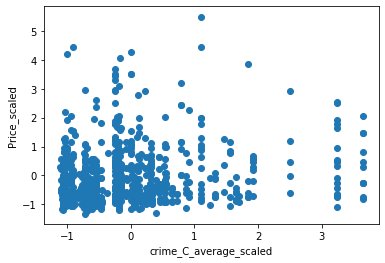

In [35]:
std_scale = preprocessing.StandardScaler().fit(houses[['Price', 'crime_C_average']])
df_std = std_scale.transform(houses[['Price', 'crime_C_average']])
houses['Price_scaled'] = df_std[:,0]
houses['crime_C_average_scaled'] = df_std[:,1]
plt.xlabel('crime_C_average_scaled')
plt.ylabel('Price_scaled')
plt.scatter(houses.crime_C_average_scaled,houses.Price_scaled)

There is no clear relationship between `Prices` and `crime_C_average`.

## Z-Score Normalisation for travel_time_to_CBD

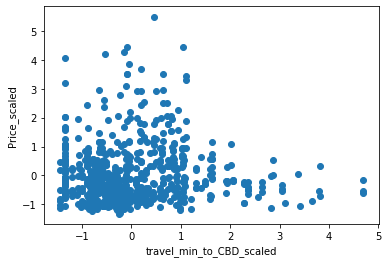

In [36]:
std_scale = preprocessing.StandardScaler().fit(houses[['Price', 'travel_min_to_CBD']])
df_std = std_scale.transform(houses[['Price', 'travel_min_to_CBD']])
houses['Price_scaled'] = df_std[:,0]
houses['travel_min_to_CBD_scaled'] = df_std[:,1]
plt.xlabel('travel_min_to_CBD_scaled')
plt.ylabel('Price_scaled')
plt.scatter(houses.travel_min_to_CBD_scaled,houses.Price_scaled)

### Result

From the above graph, we can see a slight relationship between `travel_min_to_CBD`and `Price`. We can say that `travel_min_to_CBD` can be used as one of the predictors if we were to build a linear model. 